# Logarithmic Mean Risk (Kelly Criterion) Portfolio Optimization
---
-  This method offers three options:

    -  "False" - arithmetic return (kelly=False)
    -  “approx” - approximate mean logarithmic return using first and second moment
    -  “exact” - mean logarithmic return. 
---
#### Source: [Kelly Criterion Portfolio Optimization](https://nbviewer.jupyter.org/github/dcajasn/Riskfolio-Lib/blob/master/examples/Tutorial%2022.ipynb)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")

In [3]:
yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

In [4]:
# Date range
start = '2016-01-01'
end = '2021-08-16'

In [7]:
# Select asset tickers
assets = ['BRK-B','ARKK','AGG','ETH-USD','QQQ']
assets.sort()

In [8]:
# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  5 of 5 completed


In [9]:
# Calculating returns (resample to monthly)
Y = data[assets].copy()
Y = Y.resample('M').last().pct_change().dropna()
print(Y.shape)
display(Y.head())

(67, 5)


,AGG,ARKK,BRK-B,ETH-USD,QQQ
Date,,,,,
2016-02-29,0.8870%,2.1505%,3.3906%,174.7996%,-1.5654%
2016-03-31,0.8747%,11.8714%,5.7464%,79.9514%,6.8526%
2016-04-30,0.2550%,-1.3069%,2.5373%,-22.7081%,-3.1868%
2016-05-31,0.0135%,3.2309%,-3.3957%,59.7156%,4.3700%
2016-06-30,1.9351%,-1.0262%,3.0241%,-11.4781%,-2.2780%


------
# Estimating Logarithmic Mean Variance Portfolios
------

In [10]:
import riskfolio.Portfolio as pf

# Building the portfolio object
port = pf.Portfolio(returns=Y)
# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

#port.solvers = ['MOSEK']
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

,Arithmetic,Log Approx,Log Exact
AGG,74.6591%,75.4377%,75.6589%
ARKK,0.0000%,0.0000%,0.0000%
BRK-B,7.0589%,7.0782%,7.0854%
ETH-USD,1.5683%,1.4993%,1.4801%
QQQ,16.7137%,15.9848%,15.7756%


<AxesSubplot:>

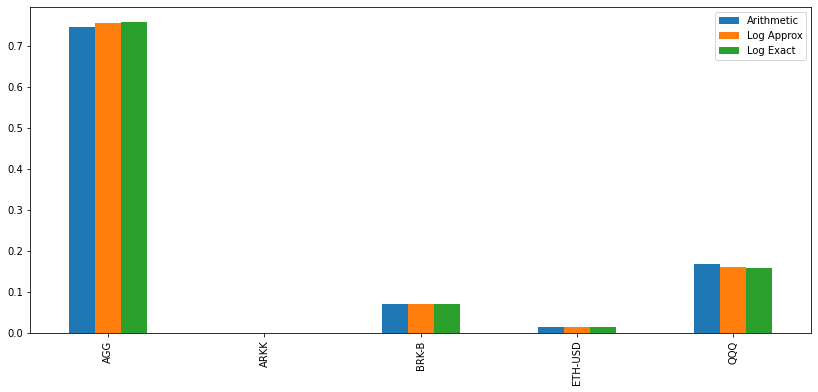

In [11]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [12]:
# Calculate returns
import riskfolio.RiskFunctions as rk

returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rk.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rk.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rk.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12**0.5)

Risk Adjusted Return:
Arithmetic 2.0625430823963256
Log Approx 2.0631592904127753
Log Exact 2.0631923112378536


In [13]:
# Calculate Efficient frontier
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AGG,ARKK,BRK-B,ETH-USD,QQQ
0,93.5676%,0.0000%,6.4324%,0.0000%,0.0000%
1,64.8507%,0.0000%,6.7974%,2.4398%,25.9120%
2,44.6786%,0.0000%,6.2494%,4.2372%,44.8347%
3,25.5387%,0.8085%,5.8684%,5.9658%,61.8186%
4,6.8275%,1.9356%,5.5348%,7.6762%,78.0258%


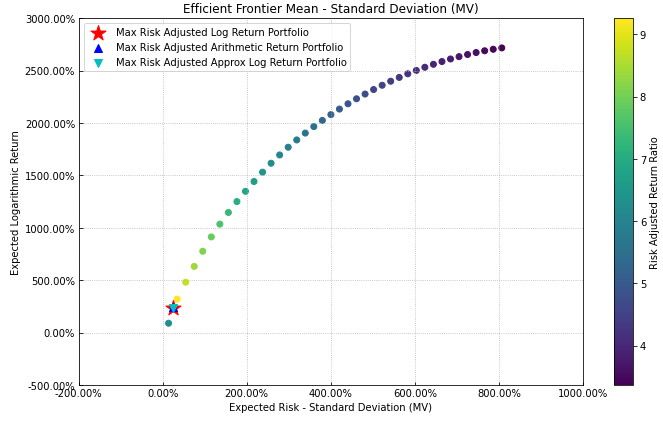

In [14]:
import riskfolio.PlotFunctions as plf

# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
plf.plot_frontier(w_frontier=frontier,
                       mu=mu,
                       cov=cov,
                       returns=returns,
                       rm=rm,
                       kelly=True,
                       rf=rf,
                       alpha=0.05,
                       cmap='viridis',
                       w=w_2,
                       label=label,
                       marker='*',
                       s=16,
                       c='r',
                       height=6,
                       width=10,
                       ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 252 
x1 = rk.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 252**0.5

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 252 
x2 = rk.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 252**0.5

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()

---
# Logarithmic Mean EVaR Portfolio
---

In [26]:
rm = 'EVaR' # Risk measure

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

,Arithmetic,Log Approx,Log Exact
AGG,85.4651%,83.8589%,83.9677%
ARKK,0.0000%,0.0000%,0.0000%
BRK-B,0.0000%,0.0000%,0.0000%
ETH-USD,8.1922%,7.1849%,7.1985%
QQQ,6.3427%,8.9562%,8.8338%


<AxesSubplot:>

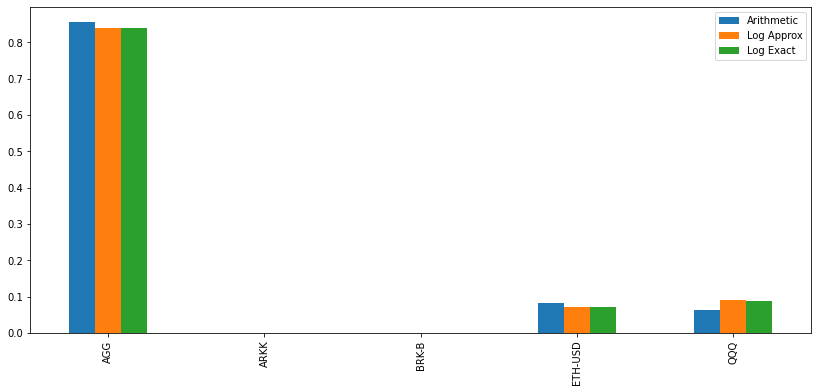

In [27]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [28]:
# Calculate returns
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rk.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rk.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rk.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12**0.5)

Risk Adjusted Return:
Arithmetic 1.6272399089377714
Log Approx 1.632875446848341
Log Exact 1.6328843378301106


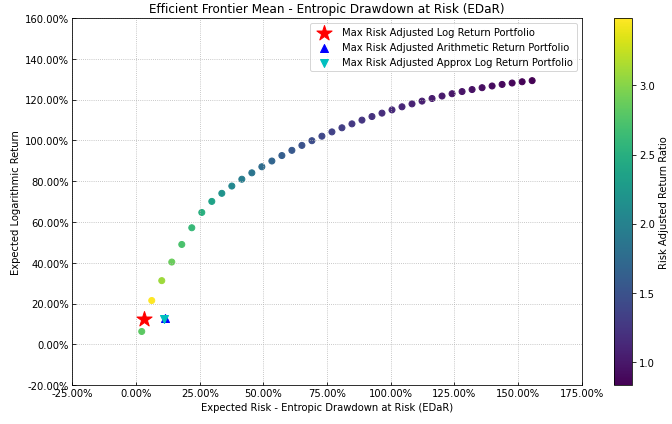

In [25]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
plf.plot_frontier(w_frontier=frontier,
                       mu=mu,
                       cov=cov,
                       returns=returns,
                       rm=rm,
                       kelly=True,
                       rf=rf,
                       alpha=0.05,
                       cmap='viridis',
                       w=w_3,
                       label=label,
                       marker='*',
                       s=16,
                       c='r',
                       height=6,
                       width=10,
                       t_factor=12,
                       ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12
x1 = rk.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12
x2 = rk.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()

---
# Logarithmic Mean EDaR Portfolio
---

In [20]:
rm = 'EDaR' # Risk measure

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

,Arithmetic,Log Approx,Log Exact
AGG,75.7368%,75.7744%,75.8032%
ARKK,1.9701%,1.2618%,1.1174%
BRK-B,5.8761%,6.0550%,6.0884%
ETH-USD,2.1641%,2.0632%,2.0407%
QQQ,14.2529%,14.8455%,14.9503%


<AxesSubplot:>

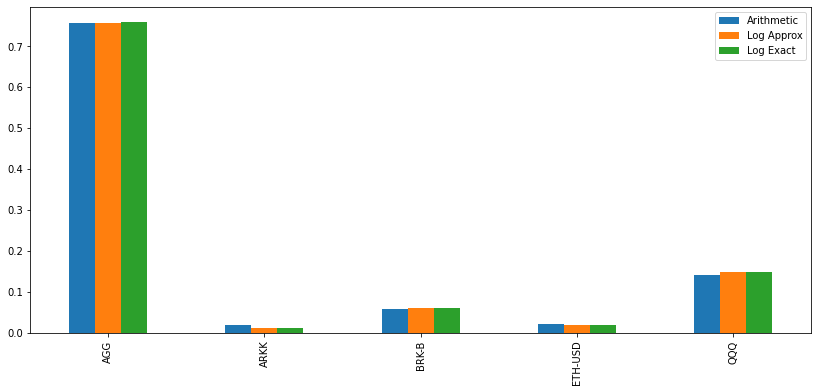

In [21]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [22]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rk.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rk.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rk.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12)

Risk Adjusted Return:
Arithmetic 3.9032667146431486
Log Approx 3.9048058055147274
Log Exact 3.9048571205160982


In [23]:
# Calculate efifcient frontier

points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AGG,ARKK,BRK-B,ETH-USD,QQQ
0,83.4718%,0.0000%,7.8474%,0.0000%,8.6808%
1,69.9013%,19.4520%,6.0657%,4.5809%,0.0000%
2,50.5949%,30.5921%,11.6818%,7.1308%,0.0003%
3,31.4897%,41.4697%,17.4261%,9.6138%,0.0006%
4,12.5365%,52.2348%,23.1581%,12.0703%,0.0002%


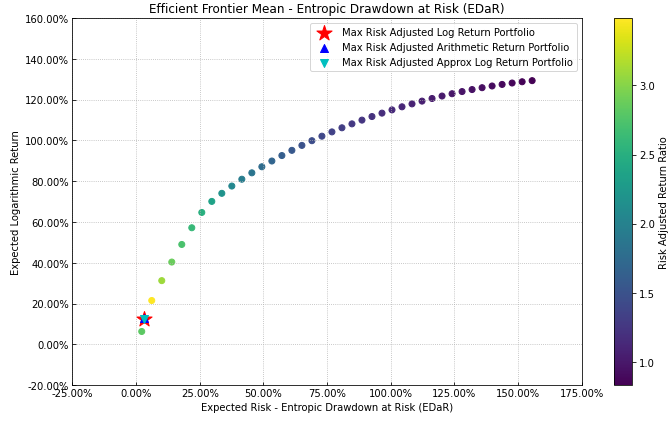

In [24]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
plf.plot_frontier(w_frontier=frontier,
                       mu=mu,
                       cov=cov,
                       returns=returns,
                       rm=rm,
                       kelly=True,
                       rf=rf,
                       alpha=0.05,
                       cmap='viridis',
                       w=w_3,
                       label=label,
                       marker='*',
                       s=16,
                       c='r',
                       height=6,
                       width=10,
                       t_factor=12,
                       ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12
x1 = rk.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12
x2 = rk.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()